In [1]:
from scipy.integrate import odeint
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


In [2]:
#set up grid
nx,ny = 100,100
x = np.linspace(0, nx, nx + 1)
y = np.linspace(0, ny, ny + 1)
X, Y = np.meshgrid(x, y)
L = 1
delta = L/nx


#charge density
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
epsilon = 8.85e-12 #F/m

#time steps
steps = 100
dt = 1e-1

#magnetic field
B = 0.1 #Tesla

In [3]:
# trial 1: not including periodic side boundary 
#create the A matrix
def create_A(nx,ny):
    A = np.zeros(((nx-1)*(ny-1),(nx-1)*(ny-1)),float)
    np.fill_diagonal(A,-4)
    np.fill_diagonal(A[:-1,1:],1)
    np.fill_diagonal(A[1:,:-1],1)

    # fill the identity matrix after first 100 rows
    # fill the identity matrix after first 100 columns
    np.fill_diagonal(A[nx-1:,:-(nx-1)],1)
    np.fill_diagonal(A[:-(nx-1),nx-1:],1)

    # fill 0s for the corners of T
    for i in range (1,(nx-1)*(nx-1)):
        for j in range (1,(ny-1)*(ny-1)):
            if (i)%(nx-1) == 0 and (j+1)%(ny-1) == 0:
                A[i,j] = 0
            if (i+1)%(nx-1) == 0 and (j)%(ny-1) == 0:
                A[i,j] = 0

    return A

def create_sparse_tridiagonal(nx, ny):
    num_diag = (nx-1)*(nx-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity]
    offsets = [0,-1,1,-(nx-1),(nx-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')
  #  return diags(diagonal, offsets, shape =(num_diag, num_diag)).toarray()

 #construct boundary vector B
def create_B():
    lil_B1 = np.zeros(((nx-1)*(ny-1),1),float)
    lil_B2 = np.zeros(((nx-1)*(ny-1),1),float)
    f = rho[1:nx,1:ny].reshape((nx-1)*(ny-1),1)*delta**2/epsilon

    lil_B1[0:nx-1] = -rho[1:ny,0].reshape(nx-1,1)
    lil_B1[(nx-1)*(ny-1)-(nx-1):(nx-1)*(ny-1)] = -rho[1:ny,ny].reshape(nx-1,1)

    lil_B2[0:(nx-1)*(ny-1):(ny-1)] = -rho[1:nx,0].reshape(nx-1,1)
    lil_B2[ny-2:(nx-1)*(ny-1):(ny-1)] = -rho[1:nx,ny].reshape(nx-1,1)

    return lil_B1+lil_B2+f

#hmm if its wrapped around, then left side = right side
#so we only need to solve one side and copy the values to the other side


def solve_poisson(rho):
    A = create_sparse_tridiagonal(nx,ny)
    B = create_B()
    rho_interior = rho[1:nx,1:ny].reshape((nx-1)*(ny-1),1)
    rho_interior = spsolve(A,B)
    rho[1:nx,1:ny] = rho_interior.reshape(nx-1,ny-1)
    #rho = side_rho_1(rho)
    return rho



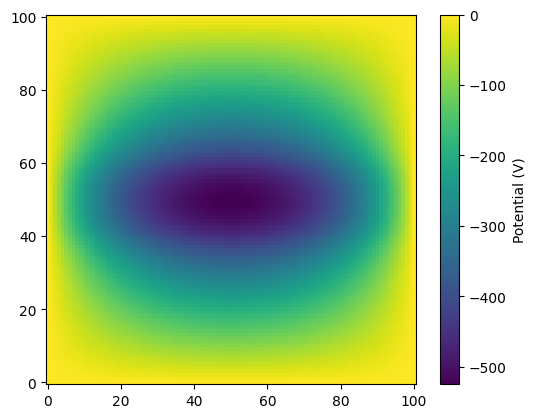

In [4]:
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho_interior = solve_poisson(rho)
plt.imshow(rho_interior, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)


In [5]:
# trial 2: including periodic side boundary
def create_sparse_tridiagonal_1(nx, ny):
    num_diag = (nx+1)*(ny-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)
    side = np.full(ny-1,1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity,side,side]
    offsets = [0,-1,1,-(nx-1),(nx-1),-nx*(ny-1),nx*(ny-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')

#construct boundary vector B
def create_B_1():
    lil_B2 = np.zeros(((nx+1)*(ny-1),1),float)
    f = rho[1:nx,0:ny+1].reshape((nx+1)*(ny-1),1,order = 'F')*delta**2/epsilon

    lil_B2[0:(nx+1)*(ny-1):(ny-1)] = -rho[0,0:nx+1].reshape((ny+1),1)
    lil_B2[ny-2:(nx+1)*(ny-1):(ny-1)] = -rho[ny,0:nx+1].reshape(ny+1,1)

    return lil_B2+f

def solve_poisson_1(rho):
    A = create_sparse_tridiagonal_1(nx,ny)
    B = create_B_1()
    rho_interior = spsolve(A,B)
    rho[1:nx,0:ny+1] = rho_interior.reshape(nx-1,ny+1,order = 'F')
    return rho

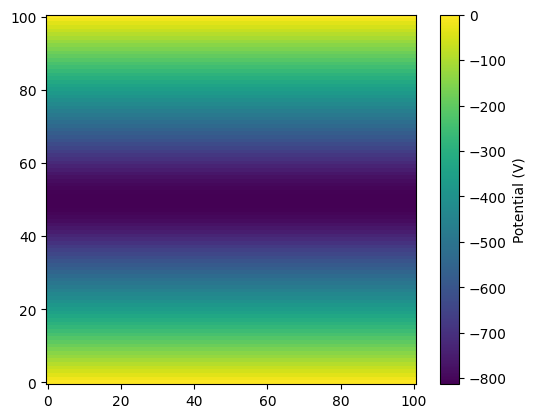

In [6]:
# solve Poisson equation with Matrix Inversion
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
rho_interior = solve_poisson_1(rho)
plt.imshow(rho_interior, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)
